# A/B Test: Using Marketing Kaggle Dataset

By: Rommel Artola <br>
Data Source: https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset/data

# A Quick Intro:

An A/B test analysis is done in moments when an analyst/data scientist wants to determine the efficacy of "doing something different". I.e., there are two groups, one is the control which receive the unaltered version of a product or service and the test group gets a modified version. One then identifies one, or a few, key indicators to measure whether the modification was effective in increase the metric. The metric can be something like, conversions, click-through rates, dollar per order, etc... 

In our specific instance, to keep this analysis direct, we will define success as click through rates (CTR) and conversion rates (CVR). Though we may analyze other metrics as well, the conclusion will be based on the aformentioned metrics.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import os

from sklearn.impute import KNNImputer
from scipy.stats import ttest_ind

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [283]:
# Setting Paths
project_repo = os.path.abspath('')
data_repo = os.path.join(project_repo, 'Data')

# Loading Dataframes and Quick Manipulations

In [290]:
# Establishing Dataframes
control_source  = pd.read_csv(os.path.join(data_repo, 'control_group.csv'), sep=';')
test_source     = pd.read_csv(os.path.join(data_repo, 'test_group.csv'), sep=';')

merged_df = (
    pd.concat(objs=[control_source, test_source], ignore_index=True)
    .assign(
        Date = lambda df: pd.to_datetime(df['Date'], format='%d.%m.%Y').dt.date
    )
)

We load the above dataframes from the source CSVs. We have to call out that the sep is ';' becauase values are delimited using the ';' key instead of the default value, commas.

Additionally, we merge (concat) the two dataframes just to perform some very quick plotting to see early distributions.

In [334]:
merged_df.sample(6)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
52,Test Campaign,2019-08-23,2407,60286.0,49329.0,5077.0,2592.0,2004.0,632.0,473.0
16,Control Campaign,2019-08-17,2177,119612.0,106518.0,6628.0,1756.0,1642.0,878.0,222.0
43,Test Campaign,2019-08-14,2537,56304.0,25982.0,3993.0,1979.0,1059.0,779.0,340.0
54,Test Campaign,2019-08-25,2928,120576.0,105978.0,3596.0,2937.0,2551.0,1228.0,651.0
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
15,Control Campaign,2019-08-16,2024,71274.0,42859.0,5224.0,2427.0,2158.0,1613.0,438.0


# Quick Descriptions

In [78]:
# Control Source Summary Stats
control_source.describe()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
count,30.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2288.433333,109559.758621,88844.931034,5320.793103,2221.310345,1943.793103,1300.000000,522.793103
std,367.334451,21688.922908,21832.349595,1757.369003,866.089368,777.545469,407.457973,185.028642
min,1757.000000,71274.000000,42859.000000,2277.000000,1001.000000,848.000000,442.000000,222.000000
25%,1945.500000,92029.000000,74192.000000,4085.000000,1615.000000,1249.000000,930.000000,372.000000
50%,2299.500000,113430.000000,91579.000000,5224.000000,2390.000000,1984.000000,1339.000000,501.000000
75%,2532.000000,121332.000000,102479.000000,6628.000000,2711.000000,2421.000000,1641.000000,670.000000
max,3083.000000,145248.000000,127852.000000,8137.000000,4891.000000,4219.000000,1913.000000,800.000000


What we can tell is that there is an instance in the control group of a missing data point. Aside from that, we see other values of distributions, but they aren't overly helpful on their own without a visual. We will have to figure out how to fill in the 7 missing NAs.

In [70]:
# Control Source Summary Stats
test_source.describe()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2563.066667,74584.800000,53491.566667,6032.333333,2418.966667,1858.000000,881.533333,521.233333
std,348.687681,32121.377422,28795.775752,1708.567263,388.742312,597.654669,347.584248,211.047745
min,1968.000000,22521.000000,10598.000000,3038.000000,1854.000000,858.000000,278.000000,238.000000
25%,2324.500000,47541.250000,31516.250000,4407.000000,2043.000000,1320.000000,582.500000,298.000000
50%,2584.000000,68853.500000,44219.500000,6242.500000,2395.500000,1881.000000,974.000000,500.000000
75%,2836.250000,99500.000000,78778.750000,7604.750000,2801.250000,2412.000000,1148.500000,701.000000
max,3112.000000,133771.000000,109834.000000,8264.000000,2978.000000,2801.000000,1391.000000,890.000000


Interestingly enough, test data is not missing any data. So, we'll have to figure out the best method of data imputation for the missing data point in the control group.

Let's plot the distributions and scatterplot using seaborn's very handy pairplot and hue by Campaign Name. Keeping in mind, we have to fill in almost an entire observation record from the control group.

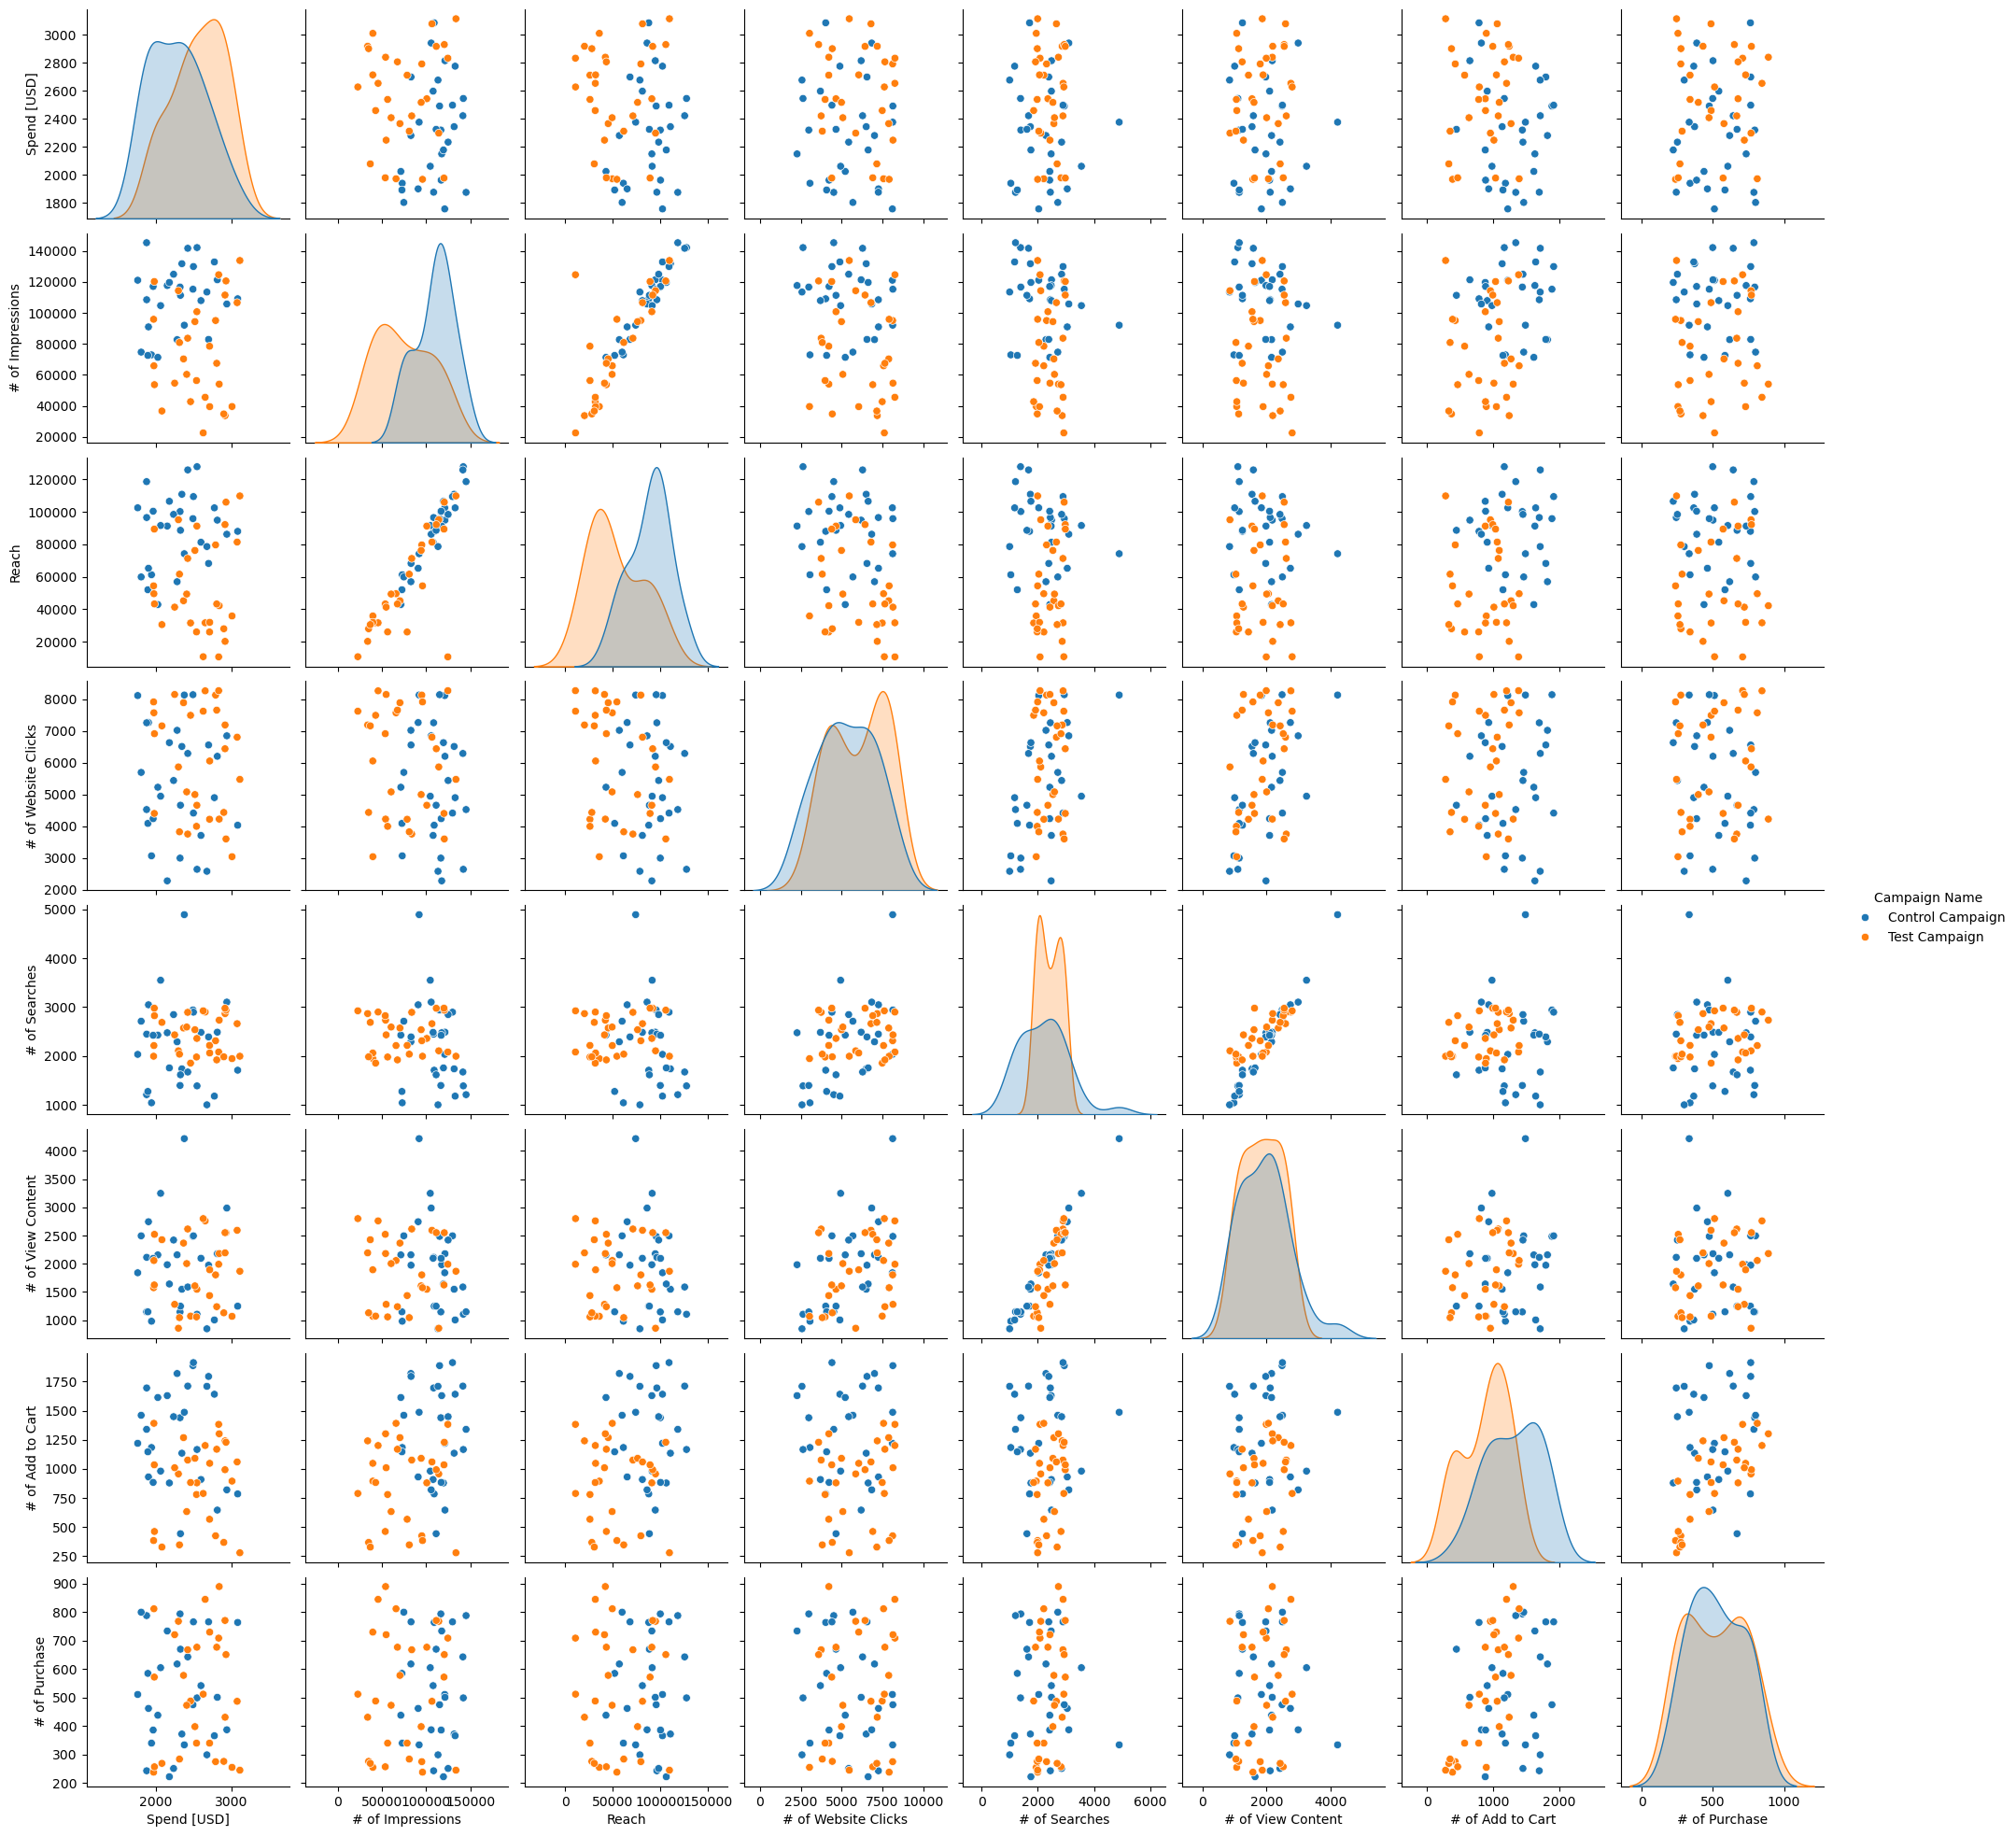

In [ ]:
# Let's do a quick visual plot of the two groups.
sns.pairplot(data=merged_df,  hue='Campaign Name')

We see a relatively good seperation between the control and the test. Some values are a bit harder to tell, like # of Purchases, while other distributions are much easier to tell apart like the Reach, total Spend, an # of Searches.

# Imputation

Let's imputate by using a KNN algorithm for imputation, using Sklearn's KNNImputate.

In [297]:
imputated_control_df = control_source.copy()

columns_with_na = imputated_control_df.columns[imputated_control_df.isna().any()]


imputer = KNNImputer(n_neighbors=3, weights='distance', metric='nan_euclidean')  # Using 3 nearest neighbors

imputated_control_df[columns_with_na] = imputer.fit_transform(imputated_control_df[columns_with_na])

print(f"Number of missing values now: {imputated_control_df.isna().sum().sum()}")

imputated_control_df.describe()

Number of missing values now: 0


,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2288.433333,109559.758621,88844.931034,5320.793103,2221.310345,1943.793103,1300.000000,522.793103
std,367.334451,21311.695472,21452.627592,1726.803732,851.025795,764.021907,400.371207,181.810508
min,1757.000000,71274.000000,42859.000000,2277.000000,1001.000000,848.000000,442.000000,222.000000
25%,1945.500000,95191.250000,75300.250000,4122.250000,1629.250000,1249.000000,942.500000,375.500000
50%,2299.500000,112368.000000,91418.000000,5272.396552,2340.000000,1979.500000,1319.500000,506.000000
75%,2532.000000,121259.000000,101958.750000,6609.500000,2655.000000,2360.500000,1638.000000,663.250000
max,3083.000000,145248.000000,127852.000000,8137.000000,4891.000000,4219.000000,1913.000000,800.000000


Great, so now we've filled in the imputated data point for control set, and we are ready to start doing some more visual explorations outside of the pairplot to see distributions. Let's look at the empirical distributions plots of all of our features, and also combine some of the features to create powerful combinations of features, and our main metrics.

By focusing on the metrics that were defined in the introduction we reduce the amount of EDA needed and can arrive more quickly at a decision to inform the business. 

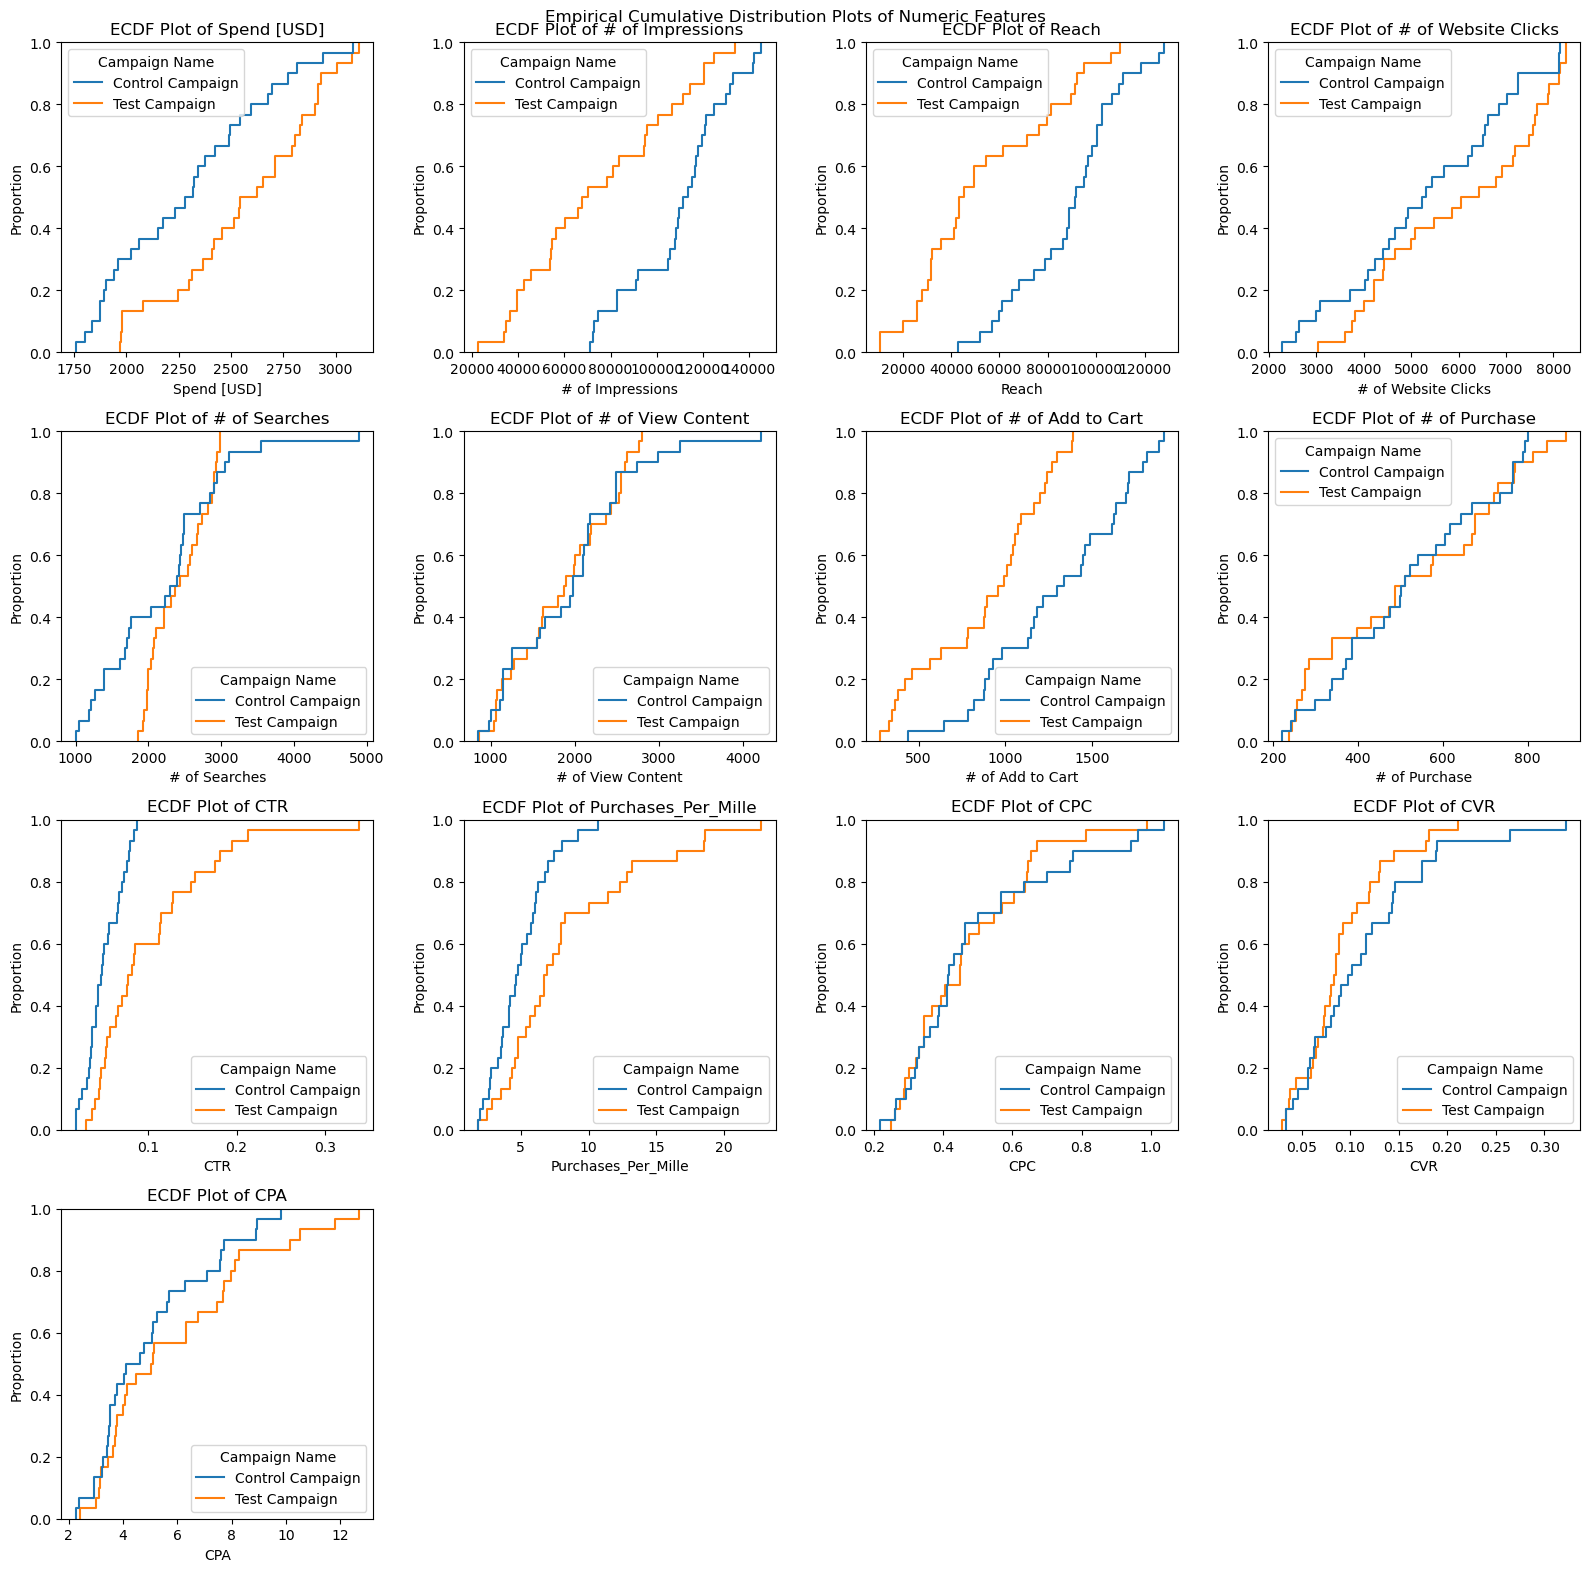

In [344]:
imputated_concat_df = (
    pd.concat(objs=[imputated_control_df, test_source], ignore_index=True)
    .assign(
        Date = lambda df: pd.to_datetime(df['Date'], format='%d.%m.%Y').dt.date,
        CTR = lambda df: df['# of Website Clicks'] / df['# of Impressions'],
        Purchases_Per_Mille = lambda df: df['# of Purchase'] / (df['# of Impressions']/1_000),
        CPC = lambda df: df['Spend [USD]'] / df['# of Website Clicks'],
        CVR = lambda df: df['# of Purchase']/df['# of Website Clicks'],
        CPA = lambda df: df['Spend [USD]'] / df['# of Purchase'],

    )
)

# We'll define all numeric columns to plot on ECDF plots.
cols_to_plot = imputated_concat_df.select_dtypes(include=[int, float]).columns.tolist()

n_cols = 4
n_rows = int(np.ceil(len(cols_to_plot) / n_cols)) 

# Create figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten() 

# Generate ECDF plots for each numeric column that we defined above.
for i, col in enumerate(cols_to_plot):
    sns.ecdfplot(data=imputated_concat_df, x=col, hue="Campaign Name", stat="proportion", ax=axes[i])
    axes[i].set_title(f"ECDF Plot of {col}")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xlabel(col)

# Below hides any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final Touches
plt.suptitle('Empirical Cumulative Distribution Plots of Numeric Features')
plt.tight_layout()
plt.show()


The ECDF are a great way to show distributions, and an alternative to histograms that I quite like. Instead of just showing counts with bins, it shows a continous x-axis of the metric of interest, and the proportion of that point, up to 100% (or 1). So, for example, in the CTR ECDF plot, we can see that Test campaign had roughly 60% of the data at or below 10% CTR. 

What the above plots are telling us for CTR and CVR between control and test is that:
* The test campaign has significantly better CTR, while the control campaign only had CTRs of 10% or less in the entire dataset.
    * So, as far as campaign differences off of CTR alone, Test Campaign seems to indicate it is much better and getting people to click on ads. But does that translate to more purchases? Let's look at CVR now.
* Assuming the exact same product was marketed, and both groups were comparable, the Control Campaign seems to perform better at getting customers to convert at higher rates. 
    * Interestingly enough, the Test Campaign had better Purchases Per Mille (per 1,000 impressions), so I am making an assumption that the Test Campaign was underserved in terms of impressions in comparison to the Control Campaign. Let's verify this.

So, what do we know and what are we verifying: 
* Test Campaign had better CTR
* Test Campaign had better Purchases Per Mille Impressions
* Control Campaign Had Better CVR

So, let's plot Impressions, # of Purchase, and Clicks to see why this is happening (as these are the metrics they're using).

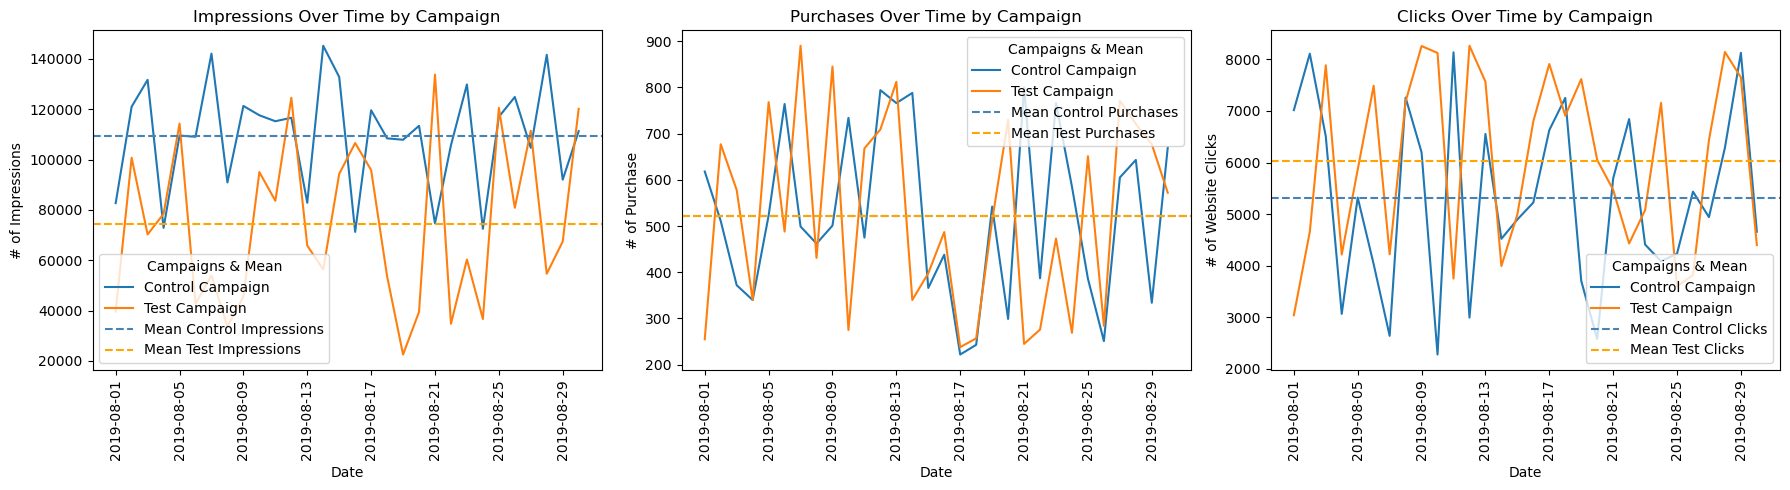

In [331]:
# Create a figure with 3 subplots in 1 row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


# Impression Plots
mean_control_impressions    = imputated_concat_df.query("`Campaign Name` == 'Control Campaign'")['# of Impressions'].mean()
mean_test_impressions       = imputated_concat_df.query("`Campaign Name` == 'Test Campaign'")['# of Impressions'].mean()

sns.lineplot(data=imputated_concat_df, x='Date', y='# of Impressions', hue='Campaign Name', ax=axes[0])
axes[0].axhline(y=mean_control_impressions, linestyle='--', color='steelblue', label='Mean Control Impressions')
axes[0].axhline(y=mean_test_impressions, linestyle='--', color='orange', label='Mean Test Impressions')

axes[0].legend(title="Campaigns & Mean")
axes[0].set_title("Impressions Over Time by Campaign")
axes[0].tick_params(axis='x', rotation=90)



# Purchases Plots
mean_control_purchases    = imputated_concat_df.query("`Campaign Name` == 'Control Campaign'")['# of Purchase'].mean()
mean_test_purchases       = imputated_concat_df.query("`Campaign Name` == 'Test Campaign'")['# of Purchase'].mean()

sns.lineplot(data=imputated_concat_df, x='Date', y='# of Purchase', hue='Campaign Name', ax=axes[1])
axes[1].axhline(y=mean_control_purchases, linestyle='--', color='steelblue', label='Mean Control Purchases')
axes[1].axhline(y=mean_test_purchases, linestyle='--', color='orange', label='Mean Test Purchases')

axes[1].legend(title="Campaigns & Mean")
axes[1].set_title("Purchases Over Time by Campaign")
axes[1].tick_params(axis='x', rotation=90)


# Clicks Plots
mean_control_clicks   = imputated_concat_df.query("`Campaign Name` == 'Control Campaign'")['# of Website Clicks'].mean()
mean_test_clicks      = imputated_concat_df.query("`Campaign Name` == 'Test Campaign'")['# of Website Clicks'].mean()

sns.lineplot(data=imputated_concat_df, x='Date', y='# of Website Clicks', hue='Campaign Name', ax=axes[2])
axes[2].axhline(y=mean_control_clicks, linestyle='--', color='steelblue', label='Mean Control Clicks')
axes[2].axhline(y=mean_test_clicks, linestyle='--', color='orange', label='Mean Test Clicks')

axes[2].legend(title="Campaigns & Mean")
axes[2].set_title("Clicks Over Time by Campaign")
axes[2].tick_params(axis='x', rotation=90)


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

So, as we can see:
* Impressions in Test Campaign are significantly less
* Purchases are almost identical between both campaigns
* Test Campaign also had more clicks.

The above explains why we saw what we saw in the ECDF plots. 
* Test Campaign had stronger purchases per mille because it had much fewer impresisons and very similar number of purchases
* Control campaign had fewer clicks and similar purchases, so the CVR would be stronger.

# Let's Visualize More About Our Metrics of Interest

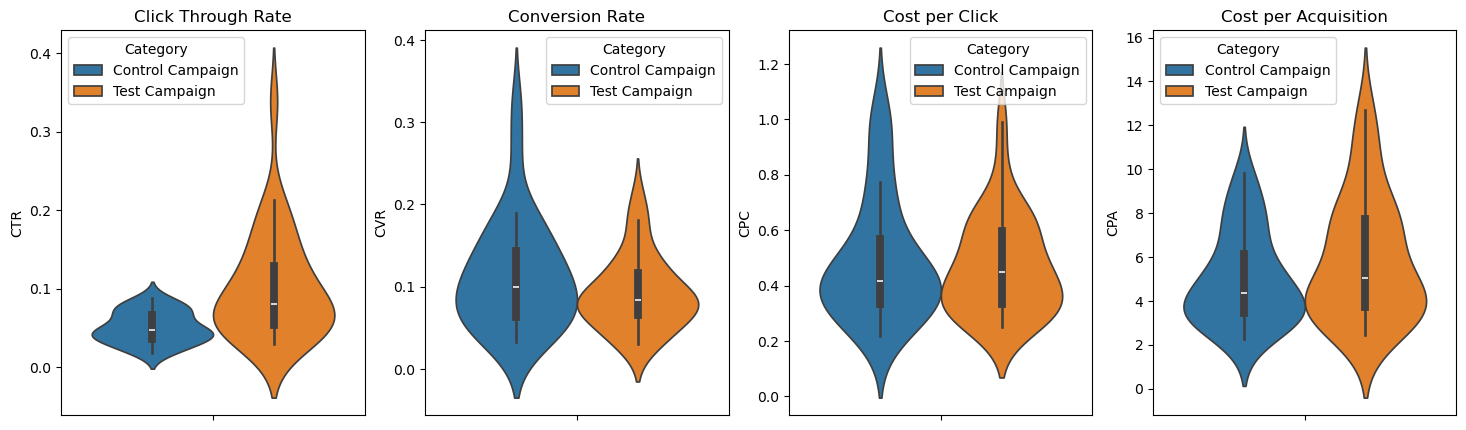

In [351]:
# Single Large Figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))


sns.violinplot(data=imputated_concat_df, y='CTR', hue='Campaign Name', ax=axes[0])
axes[0].legend(title="Category")
axes[0].set_title("Click Through Rate")

sns.violinplot(data=imputated_concat_df, y='CVR', hue='Campaign Name', ax=axes[1])
axes[1].legend(title="Category")
axes[1].set_title("Conversion Rate")

sns.violinplot(data=imputated_concat_df, y='CPC', hue='Campaign Name', ax=axes[2])
axes[2].legend(title="Category")
axes[2].set_title("Cost per Click")

sns.violinplot(data=imputated_concat_df, y='CPA', hue='Campaign Name', ax=axes[3])
axes[3].legend(title="Category")
axes[3].set_title("Cost per Acquisition")

plt.show()

# What is the above telling us?

Given all we've covered, it seems like:
* The Test Campaign had a more focused audience/segment that is very engaged but does not convert at equal rates. 
* On the other hand, the Control campaign has lower engagement but more purchasing interest/intent. 
* As far as Cost is concerned, both have very similar cost per clicks, but the Test Campaign had an inferior cost per acquisition

# Statistically Different?

In [365]:
ctrl = imputated_concat_df.query("`Campaign Name` == 'Control Campaign'")
test = imputated_concat_df.query("`Campaign Name` == 'Test Campaign'")


CTR_ttest = ttest_ind(a=ctrl['CTR'], b=test['CTR']).pvalue
CVR_ttest = ttest_ind(a=ctrl['CVR'], b=test['CVR']).pvalue
CPC_ttest = ttest_ind(a=ctrl['CPC'], b=test['CPC']).pvalue
CPA_ttest = ttest_ind(a=ctrl['CPA'], b=test['CPA']).pvalue



def t_test_func_printer(p_value, threshold, metric):
    if p_value > threshold:
        print(f'We fail to reject the null hypothesis that {metric} are statistically equal between the Test and Control Campaigns')
    else:
        print(f'We reject the null hypothesis that {metric} are statistically equal between the Test and Control Campaigns')

t_test_func_printer(CTR_ttest, 0.05, 'CTR')
t_test_func_printer(CVR_ttest, 0.05, 'CVR')
t_test_func_printer(CPC_ttest, 0.05, 'CPC')
t_test_func_printer(CPA_ttest, 0.05, 'CPA')

We reject the null hypothesis that CTR are statistically equal between the Test and Control Campaigns
We fail to reject the null hypothesis that CVR are statistically equal between the Test and Control Campaigns
We fail to reject the null hypothesis that CPC are statistically equal between the Test and Control Campaigns
We fail to reject the null hypothesis that CPA are statistically equal between the Test and Control Campaigns


# Conclusion

Given that for all the metrics above, except for CTR, the differences found in them were not statisically significant, there is not really a clear winner, but rather good information to perform a different test. 
In other words, the differences between all the metrics, except for CTR, were calculated to be no different than by pure chance alone.

The only metric that was different by *more* than just pure chance, was the Click Through Rate. This could potentially highlight a difference in audience. I.e., the Control Campaign could've been running longer, so the audience was already "filtered" and the interest was more consistent, whereas the Test Campaign could've been running for a shorter time frame, potentially exposing itself to more varied audience. 

This, of course, assumes that both campaigns were set up under the same optimization goals and expected audiences. If this is part of the difference that was set at the inception of the test, then therein lies part of the answer.

Given that, another test is recommended -- ideally an A/A or B/B test to ensure audiences are being truly similar audiences are being randomly sampled, with no selection bias.